In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import inception_cnn
from algorithms.optimized_search import OptimizedSearch
import evaluation_metrics

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import pickle

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
# Functions specific to this file
def save_results(scores, acc_drop, opt_params, output_path):
    
    with open(output_path + f'opt_params.p', 'wb') as f:
        pickle.dump(opt_params, f)
    
    with open(output_path + f'acc_drop.p', 'wb') as f:
        pickle.dump(acc_drop, f)
    
    with open(output_path + f'scores.p', 'wb') as f:
        pickle.dump(scores, f)

In [2]:
input_shape = (96, 96, 3)
num_outputs = 10 # number of classes
path_trained_weights = 'C:/Users/320060820/experiments/test_models/svhn_df/svhn_df_w.h5'
output_path = 'C:/Users/320060820/experiments/outputs/Comp_Dependent_Optimized_Search/DF SVHN/'
name = 'svhn_df'
total_acc_drop = 0.005

from test_models.svhn_df import data
_, test_data = data.get_data()

model_arch = inception_cnn.InceptionCNN(input_shape, num_outputs, dropout=True, 
                                        pool_layer_type='max', path_trained_weights=path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
layer_num = [1, 5, 3, 8, 2, 6, 4, 7, 12, 10, 15, 9, 13, 11, 14, 19, 17, 22, 16, 20, 18, 21]
layer_names = [f'conv2d_{i}' for i in layer_num] + ['binary']

In [5]:
linear = lambda x, total_acc_drop, num_layers, offset=0: total_acc_drop/num_layers * x + offset

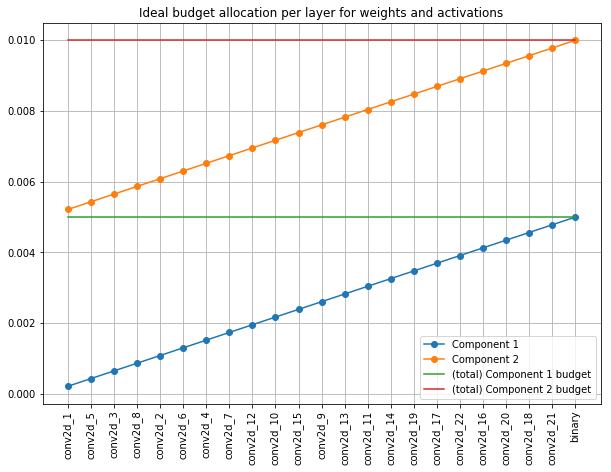

In [6]:
x = np.arange(1, len(layer_names) + 1)
plt.figure(figsize=(10, 7));
plt.title('Ideal budget allocation per layer for weights and activations');
y1 = linear(x, total_acc_drop, len(layer_names))
y2 = linear(x, total_acc_drop, len(layer_names), total_acc_drop)
plt.plot(x, y1, 'o-', label='Component 1');
plt.plot(x, y2, 'o-', label='Component 2');
plt.xticks(x, layer_names, rotation='vertical')
plt.plot(x, np.ones(y2.shape) * total_acc_drop, label='(total) Component 1 budget');
plt.plot(x, np.ones(y2.shape) * total_acc_drop*2, label='(total) Component 2 budget')
plt.grid();
plt.legend();

In [7]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(model_arch, name, test_data, float_model_acc)
w_scores, opt_params_weights, acc_drop_w = opts.run(acc_drop_config, 'weights', start_bw = 12)

{'conv2d_1': [12, 8], 'conv2d_5': [12, 9], 'conv2d_3': [12, 8], 'conv2d_6': [12, 8], 'conv2d_2': [12, 8], 'conv2d_4': [12, 8], 'conv2d_7': [12, 8], 'conv2d_8': [12, 8], 'conv2d_12': [12, 7], 'conv2d_10': [12, 7], 'conv2d_13': [12, 7], 'conv2d_9': [12, 8], 'conv2d_11': [12, 8], 'conv2d_14': [12, 7], 'conv2d_15': [12, 8], 'conv2d_19': [12, 7], 'conv2d_17': [12, 8], 'conv2d_20': [12, 6], 'conv2d_16': [12, 8], 'conv2d_18': [12, 7], 'conv2d_21': [12, 7], 'conv2d_22': [12, 8], 'binary': [12, 10]}
Quantizing layer conv2d_1
Global opt: (6, 3) Local opt: (6, 3) Performance diff: 0.000000
Chosen:  (6, 3)
After quantizing weights of layer conv2d_1 | Measured accuracy drop -0.000833 | Acceptable accuracy drop: 0.000217
Quantizing layer conv2d_5
Global opt: (2, -1) Local opt: (2, -2) Performance diff: 0.000250
Chosen:  (2, -2)
After quantizing weights of layer conv2d_5 | Measured accuracy drop -0.000875 | Acceptable accuracy drop: 0.000435
Quantizing layer conv2d_3
Global opt: (4, 0) Local opt: (3,

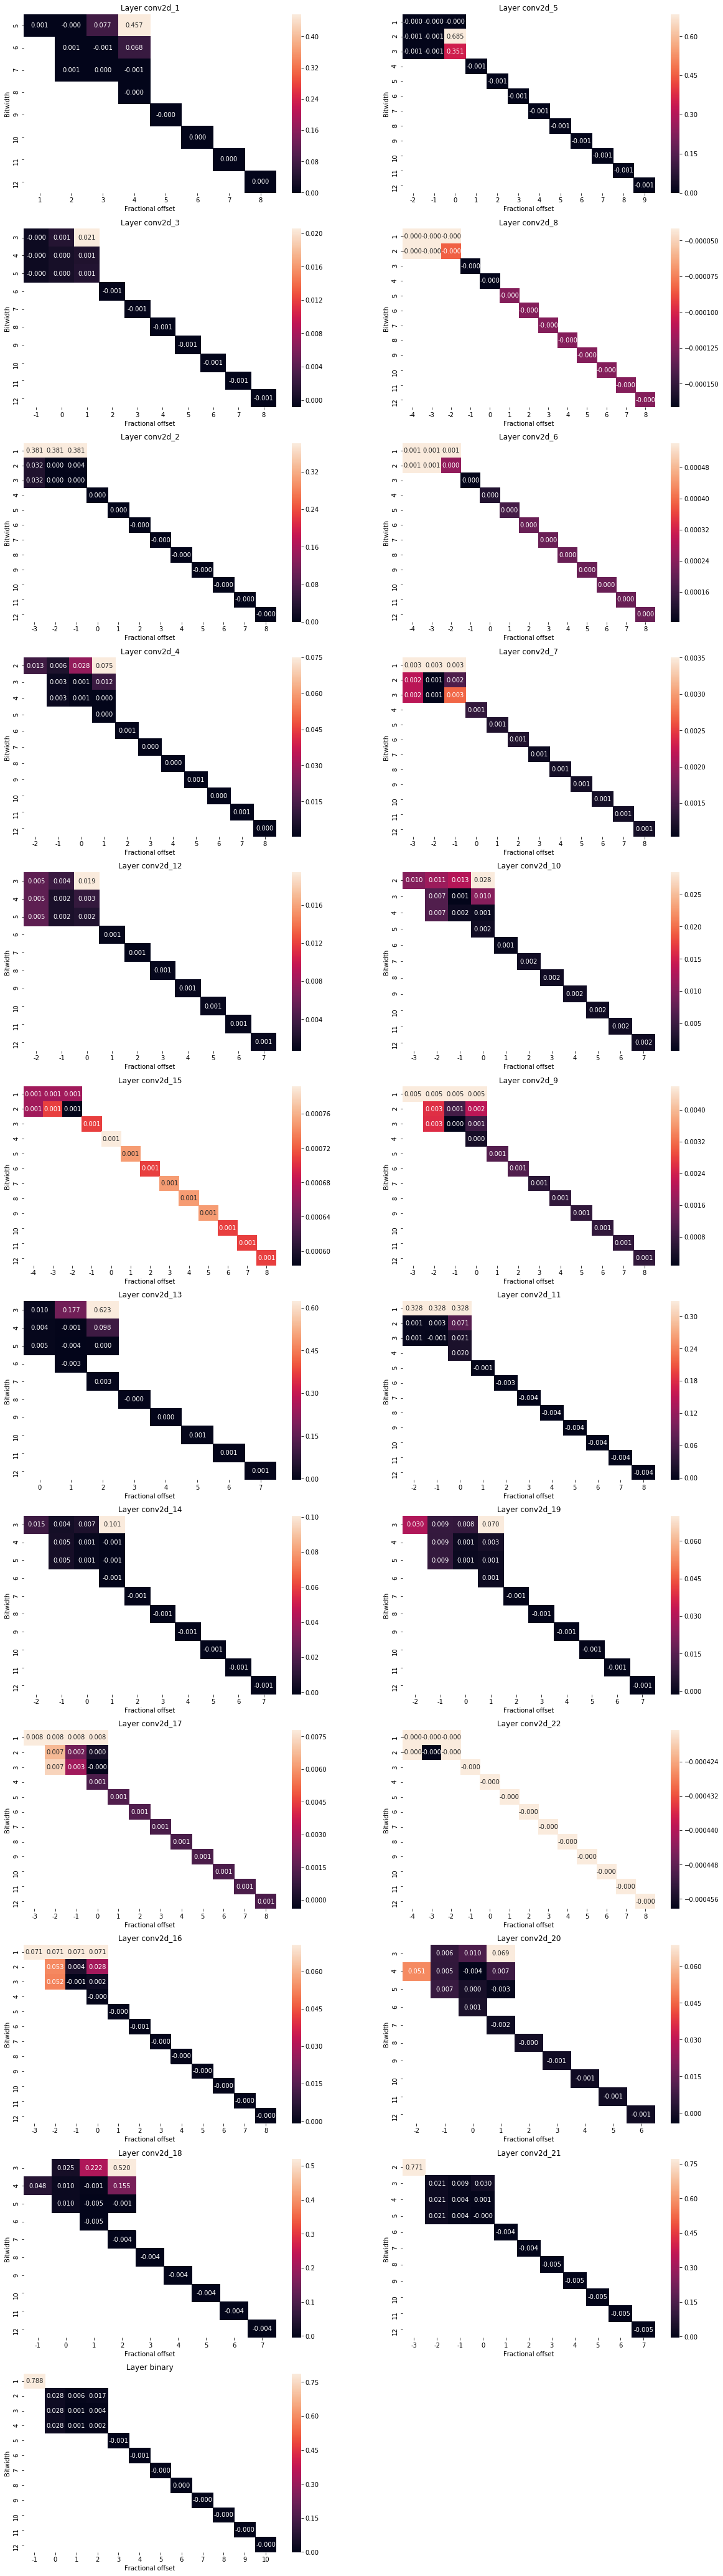

In [8]:
opts.plot_scores_matrix(w_scores, 12, 2, (20, 75))

In [12]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (6, 3), 'conv2d_5': (2, -2), 'conv2d_3': (3, -1), 'conv2d_8': (1, -3), 'conv2d_2': (2, -2), 'conv2d_6': (1, -3), 'conv2d_4': (3, 0), 'conv2d_7': (2, -2), 'conv2d_12': (4, -1), 'conv2d_10': (3, -1), 'conv2d_15': (1, -3), 'conv2d_9': (2, -1), 'conv2d_13': (5, 1), 'conv2d_11': (3, -1), 'conv2d_14': (5, 1), 'conv2d_19': (4, 0), 'conv2d_17': (3, 0), 'conv2d_22': (1, -3), 'conv2d_16': (3, -1), 'conv2d_20': (4, 0), 'conv2d_18': (5, 1), 'conv2d_21': (5, 0), 'binary': (3, 1)}, biases={}, activations={})

{'conv2d_1': [8, 6], 'conv2d_5': [8, 5], 'conv2d_3': [8, 4], 'conv2d_6': [8, 5], 'conv2d_2': [8, 4], 'conv2d_4': [8, 4], 'conv2d_7': [8, 6], 'conv2d_8': [8, 5], 'conv2d_12': [8, 3], 'conv2d_10': [8, 5], 'conv2d_13': [8, 5], 'conv2d_9': [8, 5], 'conv2d_11': [8, 5], 'conv2d_14': [8, 4], 'conv2d_15': [8, 4], 'conv2d_19': [8, 4], 'conv2d_17': [8, 4], 'conv2d_20': [8, 5], 'conv2d_16': [8, 4], 'conv2d_18': [8, 4], 'conv2d_21': [8, 3], 'conv2d_22': [8, 5], 'binary': [8, 6]}
Quantizing layer conv2d_1
Global opt: (1, -1) Local opt: (1, -2) Performance diff: 0.000000
Chosen:  (1, -2)
After quantizing biases of layer conv2d_1 | Measured accuracy drop -0.000667 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_5
Global opt: (1, -2) Local opt: (1, -3) Performance diff: 0.000000
Chosen:  (1, -3)
After quantizing biases of layer conv2d_5 | Measured accuracy drop -0.000667 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_3
Global opt: (1, -3) Local opt: (2, -3) Performance diff:

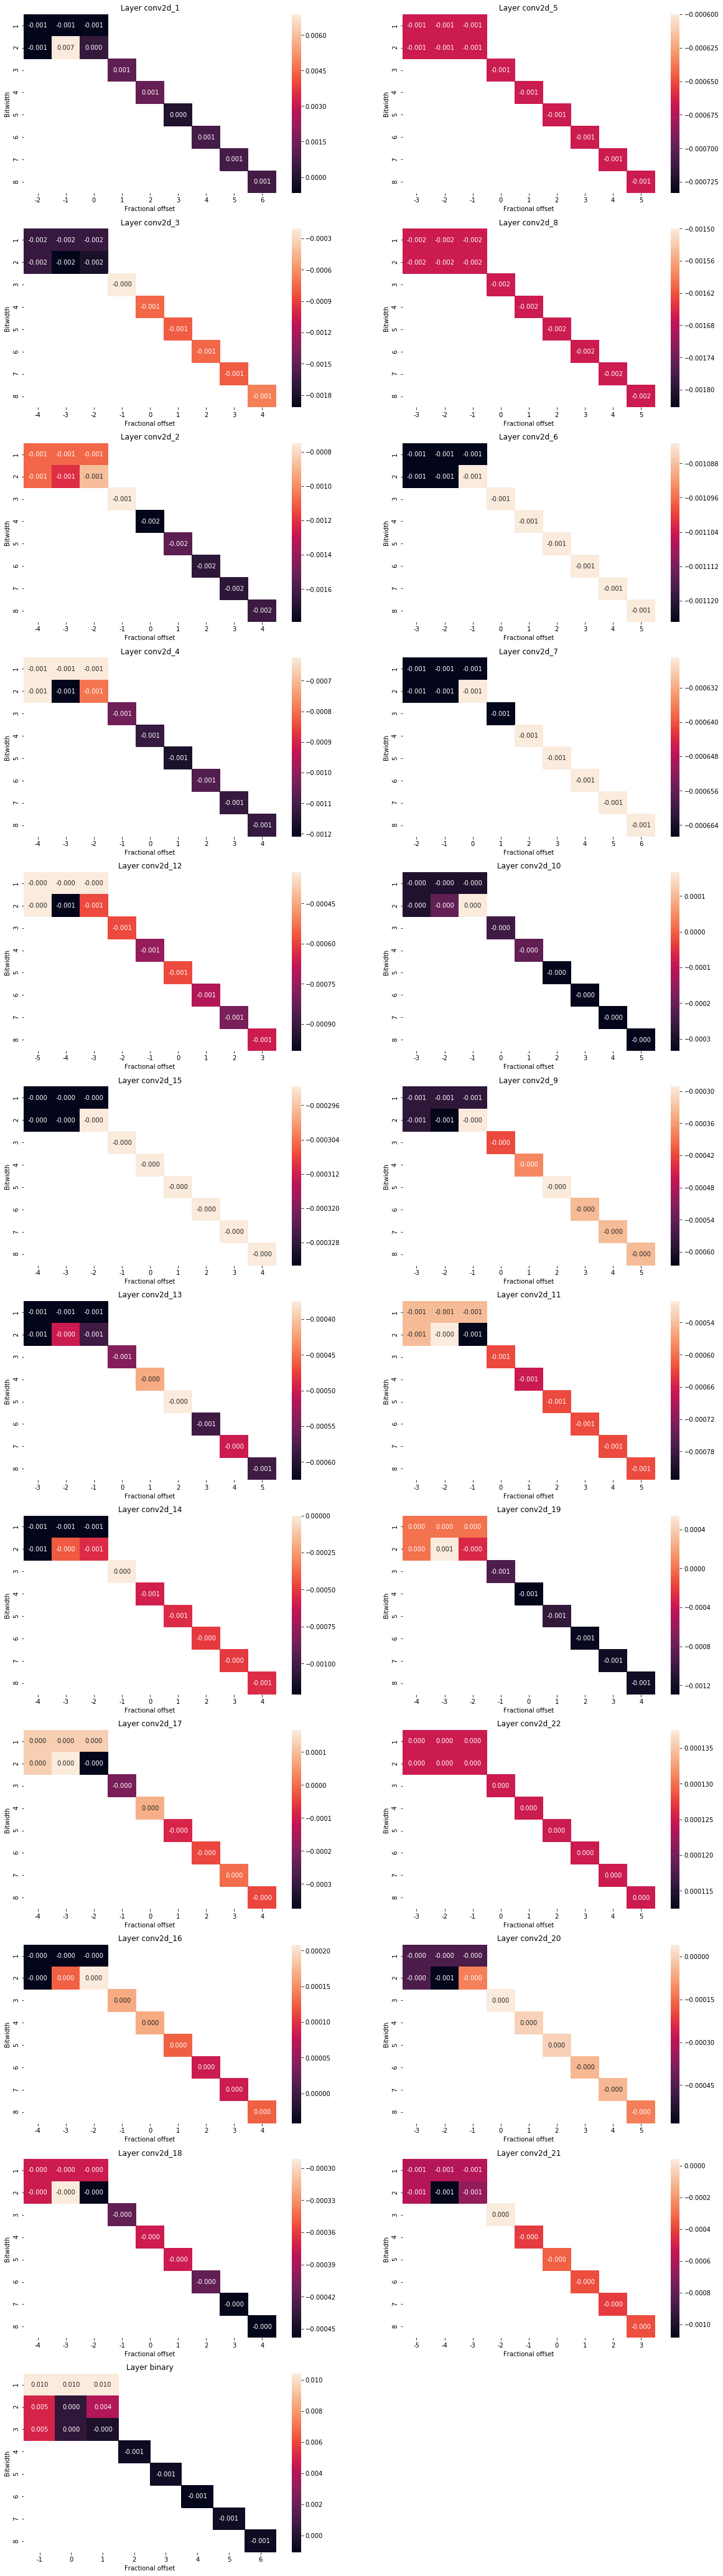

In [13]:
acc_drop_config = {
    layer_names[i - 1]: total_acc_drop for i in range(1, len(layer_names) + 1)
}

b_scores, opt_params_biases, acc_drop_b = opts.run(acc_drop_config, 'biases', start_bw = 8)
opts.plot_scores_matrix(b_scores, 12, 2, (20, 75))

In [15]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (6, 3), 'conv2d_5': (2, -2), 'conv2d_3': (3, -1), 'conv2d_8': (1, -3), 'conv2d_2': (2, -2), 'conv2d_6': (1, -3), 'conv2d_4': (3, 0), 'conv2d_7': (2, -2), 'conv2d_12': (4, -1), 'conv2d_10': (3, -1), 'conv2d_15': (1, -3), 'conv2d_9': (2, -1), 'conv2d_13': (5, 1), 'conv2d_11': (3, -1), 'conv2d_14': (5, 1), 'conv2d_19': (4, 0), 'conv2d_17': (3, 0), 'conv2d_22': (1, -3), 'conv2d_16': (3, -1), 'conv2d_20': (4, 0), 'conv2d_18': (5, 1), 'conv2d_21': (5, 0), 'binary': (3, 1)}, biases={'conv2d_1': (1, -2), 'conv2d_5': (1, -3), 'conv2d_3': (1, -3), 'conv2d_8': (1, -3), 'conv2d_2': (1, -3), 'conv2d_6': (1, -3), 'conv2d_4': (1, -3), 'conv2d_7': (1, -2), 'conv2d_12': (1, -4), 'conv2d_10': (1, -3), 'conv2d_15': (1, -4), 'conv2d_9': (1, -2), 'conv2d_13': (1, -3), 'conv2d_11': (1, -2), 'conv2d_14': (1, -4), 'conv2d_19': (1, -3), 'conv2d_17': (1, -3), 'conv2d_22': (1, -3), 'conv2d_16': (1, -4), 'conv2d_20': (1, -2), 'conv2d_18': (1, -3), 'conv2d_21': (1, -4), 

{'conv2d_1': [12, 5], 'conv2d_5': [12, 5], 'conv2d_3': [12, 4], 'conv2d_6': [12, 2], 'conv2d_2': [12, 4], 'conv2d_4': [12, 0], 'conv2d_7': [12, 2], 'conv2d_8': [12, 4], 'conv2d_12': [12, 2], 'conv2d_10': [12, 1], 'conv2d_13': [12, 1], 'conv2d_9': [12, 1], 'conv2d_11': [12, 0], 'conv2d_14': [12, 1], 'conv2d_15': [12, 2], 'conv2d_19': [12, 2], 'conv2d_17': [12, 2], 'conv2d_20': [12, 0], 'conv2d_16': [12, 2], 'conv2d_18': [12, 0], 'conv2d_21': [12, 0], 'conv2d_22': [12, 3], 'binary': [12, 6]}
Quantizing layer conv2d_1
Global opt: (7, 2) Local opt: (8, 3) Performance diff: 0.001000
Chosen:  (7, 2)
After quantizing activations of layer conv2d_1 | Measured accuracy drop 0.000375 | Acceptable accuracy drop: 0.005217
Quantizing layer conv2d_5
Global opt: (1, -6) Local opt: (1, -7) Performance diff: 0.000000
Chosen:  (1, -7)
After quantizing activations of layer conv2d_5 | Measured accuracy drop 0.000375 | Acceptable accuracy drop: 0.005435
Quantizing layer conv2d_3
Global opt: (4, -2) Local op

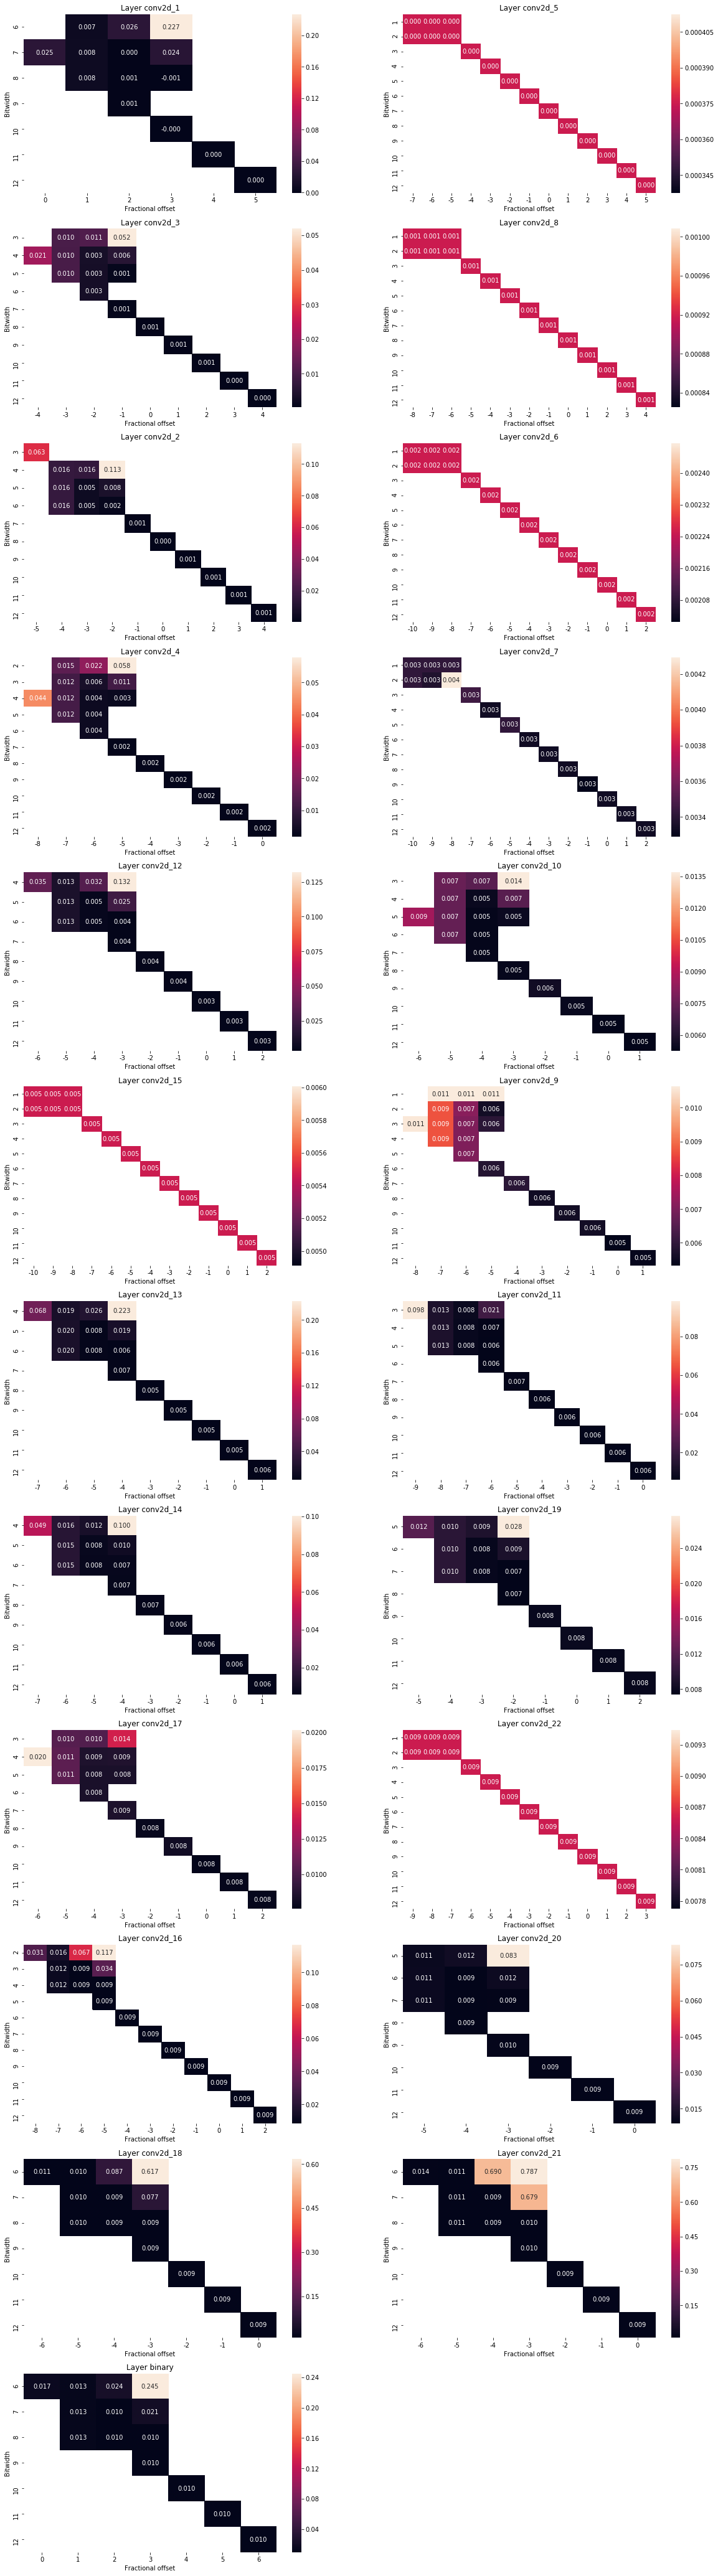

In [16]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names), total_acc_drop) for i in range(1, len(layer_names) + 1)
}

a_scores, opt_params_act, acc_drop_a = opts.run(acc_drop_config, 'activations', start_bw = 12)
opts.plot_scores_matrix(a_scores, 12, 2, (20, 75))

In [17]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (6, 3), 'conv2d_5': (2, -2), 'conv2d_3': (3, -1), 'conv2d_8': (1, -3), 'conv2d_2': (2, -2), 'conv2d_6': (1, -3), 'conv2d_4': (3, 0), 'conv2d_7': (2, -2), 'conv2d_12': (4, -1), 'conv2d_10': (3, -1), 'conv2d_15': (1, -3), 'conv2d_9': (2, -1), 'conv2d_13': (5, 1), 'conv2d_11': (3, -1), 'conv2d_14': (5, 1), 'conv2d_19': (4, 0), 'conv2d_17': (3, 0), 'conv2d_22': (1, -3), 'conv2d_16': (3, -1), 'conv2d_20': (4, 0), 'conv2d_18': (5, 1), 'conv2d_21': (5, 0), 'binary': (3, 1)}, biases={'conv2d_1': (1, -2), 'conv2d_5': (1, -3), 'conv2d_3': (1, -3), 'conv2d_8': (1, -3), 'conv2d_2': (1, -3), 'conv2d_6': (1, -3), 'conv2d_4': (1, -3), 'conv2d_7': (1, -2), 'conv2d_12': (1, -4), 'conv2d_10': (1, -3), 'conv2d_15': (1, -4), 'conv2d_9': (1, -2), 'conv2d_13': (1, -3), 'conv2d_11': (1, -2), 'conv2d_14': (1, -4), 'conv2d_19': (1, -3), 'conv2d_17': (1, -3), 'conv2d_22': (1, -3), 'conv2d_16': (1, -4), 'conv2d_20': (1, -2), 'conv2d_18': (1, -3), 'conv2d_21': (1, -4), 

In [18]:
model_obj = fxp_quantize.fix_model_quantization(model_arch, name, test_data, opts.quant_evaluator.quant_params)
print(f'Floating point network accuracy: {float_model_acc * 100}%')
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Fixed-point network accuracy: {fxp_model_acc * 100}%')
print(f'Accuracy loss of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f}%')

# Save results
scores = {
    'weights': w_scores,
    'biases': b_scores,
    'activations': a_scores
}
acc_drop = {
    'weights': acc_drop_w,
    'biases': acc_drop_b,
    'activations': acc_drop_a
}

save_results(scores, acc_drop, opts.quant_evaluator.quant_params._asdict(), output_path)

Floating point network accuracy: 92.1980639213276%
Fixed-point network accuracy: 91.279963122311%
Accuracy loss of 0.996%
